In [1]:
import warnings               # To suppress warnings

import numpy as np            # Data manipulation
import pandas as pd           # Dataframe manipulation
import matplotlib.pyplot as plt                   # For graphics
import seaborn as sns
import plotly as py #For World Map
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
from sklearn.preprocessing import StandardScaler  # For scaling dataset
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation #For clustering
from sklearn.mixture import GaussianMixture #For GMM clustering

import os                     # For os related operations
import sys   
import datetime
import wbdata
%matplotlib inline

c:\python35\lib\site-packages\plotly\tools.py:102: UserWarning:

Looks like you don't have 'read-write' permission to your 'home' ('~') directory or to our '~/.plotly' directory. That means plotly's python api can't setup local configuration files. No problem though! You'll just have to sign-in using 'plotly.plotly.sign_in()'. For help with that: 'help(plotly.plotly.sign_in)'.
Questions? Visit https://support.plot.ly



In [2]:
indicators = {
              'SL.EMP.WORK.ZS': 'Wage and salaried workers, total',
              'SL.EMP.VULN.ZS': 'Vulnerable employment, total',
              'NY.GDP.PCAP.KD.ZG': 'GDP growth per capita annual %',
              'per_si_allsi.adq_pop_tot': 'Adequacy of social insurance programs',
              'SL.ISV.IFRM.ZS': 'Informal employment',
              'SL.TLF.PART.ZS': 'Part time employment, total',
              'per_allsp.adq_pop_tot': 'Adequacy of social protection and labor programs',
              'SL.TLF.0714.ZS': 'Children in employment, total',
              'per_si_allsi.cov_pop_tot': 'Coverage of social insurance programs',
              'per_sa_allsa.adq_pop_tot': 'Adequacy of social safety net programs ',
              'per_lm_alllm.cov_pop_tot': 'Coverage of unemployment benefits and ALMP'
}

In [3]:
data_dates = datetime.datetime(2014,1,1)
# data_dates = (datetime.datetime(2013,1,1), datetime.datetime(2017,1,1))
df = wbdata.get_dataframe(indicators, country='all', convert_date=True, data_date=data_dates)
# df = df.iloc[::-1]
# df.fillna(0, inplace=True)
df = df.iloc[48:]
df = df[(df[['GDP growth per capita annual %', 'Vulnerable employment, total',
             'Wage and salaried workers, total',
             'Adequacy of social insurance programs',
            'Informal employment', 'Part time employment, total',
            'Adequacy of social protection and labor programs',
            'Children in employment, total', 
             'Part time employment, total']] != 0).all(axis=1)]

In [4]:
df['Non-Vulnerable employment, total'] = 100 - df['Vulnerable employment, total']
df['Non-Informal employment'] = 100 - df['Informal employment']
# df['Non-Part time employment, total'] = 100 - df['Part time employment, total']
df['Children not in employment, total'] = 100 - df['Children in employment, total']


df.drop(df.columns[[1, 4, 5, 7, 10]], axis=1, inplace=True)
df.dropna(inplace=True)

df_rat = pd.read_csv('ILO-convention-ratification-status.csv')
df_rat = df_rat.set_index('country')

df_wpov = pd.read_csv('working_poverty.csv')
df_wpov = df_wpov.set_index('country')
new_df = pd.concat([df, df_rat], axis=1)
new_df = pd.concat([new_df, df_wpov], axis=1)

new_df['not working poverty'] = 100 - new_df['working poverty']

new_df.drop('working poverty', axis=1, inplace=True)



new_df['decent work score'] = new_df.mean(axis=1)
df_real = new_df.copy()
df_real.drop('GDP growth per capita annual %', axis=1, inplace=True)


df_real.to_csv(r'wbdata.csv')
onlyscore_df = df_real['decent work score']
onlyscore_df.to_csv(r'decent_work_score.csv')

In [5]:
print("Dimension of dataset:", new_df.shape)
new_df.dtypes

Dimension of dataset: (5, 12)


Adequacy of social insurance programs      float64
Adequacy of social safety net programs     float64
Children in employment, total              float64
GDP growth per capita annual %             float64
Part time employment, total                float64
Vulnerable employment, total               float64
Non-Vulnerable employment, total           float64
Non-Informal employment                    float64
Children not in employment, total          float64
ILO conventions ratification status        float64
not working poverty                        float64
decent work score                          float64
dtype: object

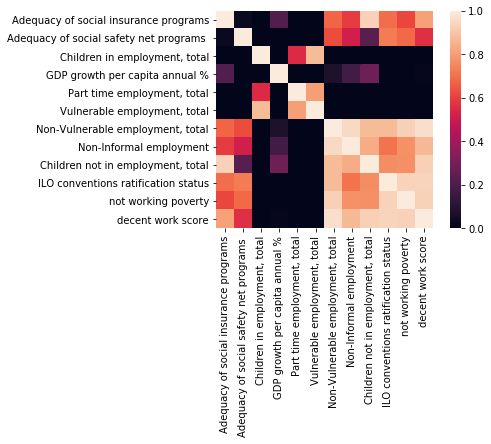

In [6]:
cor = new_df.corr()
sns.heatmap(cor, square = True, vmin=0, vmax=1)

In [7]:
df2 = new_df.reset_index()
data = dict(type='choropleth',
           locations=df2['country'],
           locationmode = 'country names',
           z = df2['decent work score'],
           text = df2['country'],
           colorbar = {'title':  'Decent work'})
layout = dict(title = 'Decent Work Index',
            geo = dict(showframe= False,
                      projection = {'type': 'mercator'}))

choromap3 = go.Figure(data = [data], layout=layout)
iplot(choromap3)

In general, k-means is the first choice for clustering because of its simplicity. Here, the user has to define the number of clusters. The clusters are formed based on the closeness to the center value of the clusters. The initial center value is chosen randomly. K-means clustering is top-down approach, in the sense, we decide the number of clusters (k) and then group the data points into k clusters.

In [8]:
def doKmeans(X, nclust=2):
    model = KMeans(nclust)
    model.fit(X)
    clust_labels = model.predict(X)
    cent = model.cluster_centers_
    return (clust_labels, cent)

clust_labels, cent = doKmeans(df_real, 2)
kmeans = pd.DataFrame(clust_labels)
df_real.insert((df_real.shape[1]),'kmeans',kmeans)
df_real = df_real.reset_index()

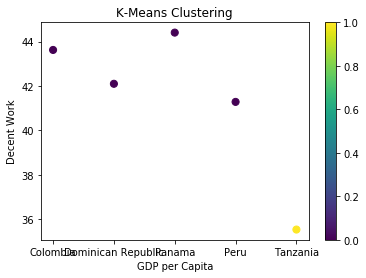

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(df_real['country'],df_real['decent work score'],
                     c=kmeans[0], s=50)
ax.set_title('K-Means Clustering')
ax.set_xlabel('GDP per Capita')
ax.set_ylabel('Decent Work')
plt.colorbar(scatter)